<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Alert statistics

## Goal

This notebook shows how to explore the various statistics that are collected in Fink regarding alerts.

## Statistics API

The [statistics](https://fink-portal.org/stats) page makes use of the REST API. If you want to further explore Fink statistics, or create your own dashboard based on Fink data, you can do also all of these yourself using the REST API. Here is an example using Python:

In [1]:
import io
import requests
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

from astropy.time import Time

In [2]:
# get stats since the beginning of Fink operations
r = requests.post(
  'https://fink-portal.org/api/v1/statistics',
  json={
    'date': '', # could be also e.g. 20211103
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

Note `date` can be either a given night (`YYYYMMDD`), month (`YYYYMM`), year (`YYYY`), or eveything (empty string). The schema of the dataframe is the following:

In [3]:
print(pdf.columns)

Index(['basic:exposures', 'basic:fields', 'basic:n_g', 'basic:n_r',
       'basic:raw', 'basic:sci', 'class:**', 'class:**_Candidate',
       'class:AGB*', 'class:AGB*_Candidate',
       ...
       'class:multiple_object', 'class:outflow?', 'class:post-AGB*',
       'class:post-AGB*_Candidate', 'class:pulsV*SX', 'class:radioBurst',
       'class:simbad_gal', 'class:simbad_tot', 'key:key', 'key:time'],
      dtype='object', length=254)


In [4]:
pdf

,basic:exposures,basic:fields,basic:n_g,basic:n_r,basic:raw,basic:sci,class:**,class:**_Candidate,class:AGB*,class:AGB*_Candidate,...,class:multiple_object,class:outflow?,class:post-AGB*,class:post-AGB*_Candidate,class:pulsV*SX,class:radioBurst,class:simbad_gal,class:simbad_tot,key:key,key:time
0,371,234,120721,90025,267126,210746,8.0,NaN,76.0,NaN,...,NaN,None,4.0,NaN,3.0,NaN,1114,61007,ztf_20191102,1642416932927
1,421,259,94127,110370,267509,204497,10.0,NaN,62.0,NaN,...,NaN,None,4.0,NaN,3.0,NaN,622,74121,ztf_20191103,1642417432819
2,420,221,94059,84545,254314,178604,24.0,NaN,53.0,NaN,...,NaN,None,2.0,NaN,4.0,NaN,782,65090,ztf_20191104,1642417906840
3,223,151,26747,60149,124028,86896,9.0,NaN,38.0,NaN,...,1.0,None,3.0,NaN,1.0,NaN,218,34706,ztf_20191105,1642418198542
4,336,211,51308,88214,186244,139522,8.0,NaN,50.0,NaN,...,NaN,None,1.0,NaN,5.0,NaN,414,55624,ztf_20191106,1642418566575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,325,160,88888,93234,237849,182122,313.0,NaN,61.0,60.0,...,17.0,None,8.0,1.0,5.0,2.0,6974,95480,ztf_20230427,1682622995580
812,321,154,49045,61525,158886,110570,184.0,NaN,31.0,32.0,...,10.0,None,8.0,NaN,3.0,2.0,5654,57905,ztf_20230428,1682707266824
813,301,143,74686,89470,204344,164156,227.0,NaN,36.0,37.0,...,20.0,None,6.0,2.0,3.0,2.0,8134,85437,ztf_20230429,1682795224874
814,270,129,43941,68159,203203,112100,4.0,NaN,51.0,24.0,...,2.0,None,3.0,1.0,1.0,NaN,858,47251,ztf_20230430,1682879906853


Let's see the number of alerts received and processed by Fink:

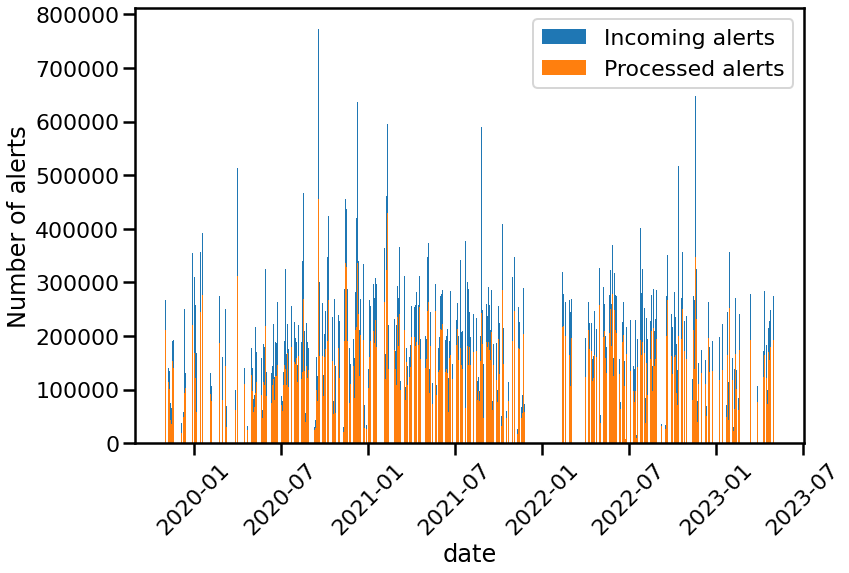

In [10]:
date = [
    Time(x[4:8] + '-' + x[8:10] + '-' + x[10:12]).datetime
    for x in pdf['key:key'].values
]

fig = plt.figure(figsize=(12, 8))

plt.bar(date, pdf['basic:raw'], label='Incoming alerts')
plt.bar(date, pdf['basic:sci'], label='Processed alerts')
plt.xlabel('date')
plt.ylabel('Number of alerts')
plt.xticks(rotation=45)
plt.legend();

Let's see the evolution for various classes:

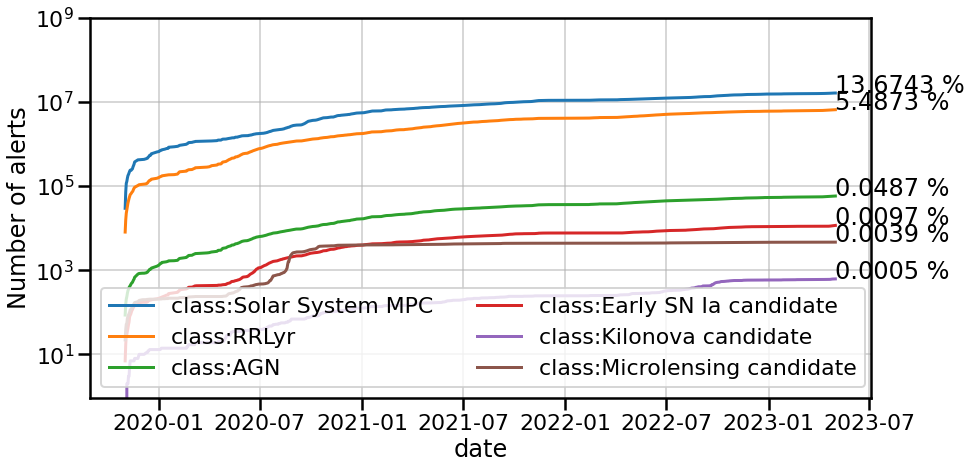

In [6]:
import numpy as np

fig = plt.figure(figsize=(14, 7))

cols = [
    'class:Solar System MPC', 'class:RRLyr', 
    'class:AGN', 'class:Early SN Ia candidate',
    'class:Kilonova candidate', 'class:Microlensing candidate',
]

# Number of alerts processed
nprocessed = np.sum(pdf[['basic:sci']].fillna(0).astype(int).values)

for col in cols:
    # replace NaN (no observations) by zeros
    vals = pdf[[col]].fillna(0).astype(int)
    
    # Cumulative
    cum = np.cumsum(vals.values)
    
    plt.plot(date, cum, label=col)
    plt.text(s='{:.4f} %'.format(cum[-1]/nprocessed * 100), x=date[-1], y=cum[-1])
    
    
plt.xlabel('date')
plt.ylabel('Number of alerts')
plt.yscale('log')
plt.ylim(None, 1e9)
plt.grid(alpha=0.5)
plt.legend(ncol=2);

## Tips

If you then want to retrieve the corresponding alerts, pay attention to the data you want to transfer:

In [7]:
import requests
import pandas as pd

def get_alerts(cols='*'):
    # Get all SN Ia candidate for 2021
    r = requests.post(
      'https://fink-portal.org/api/v1/latests',
      json={
        'class': 'Early SN Ia candidate',
        'n': '10000',
        'columns': cols,
        'startdate': '2021-01-01',
        'stopdate': '2021-12-31'
      }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(io.BytesIO(r.content))
    
    return pdf

In [8]:
# all columns by default
%time _ = get_alerts()

CPU times: user 86.5 ms, sys: 29.1 ms, total: 116 ms
Wall time: 10.9 s


In [9]:
# Just 4 columns
%time _ = get_alerts(cols='i:magpsf,i:jd,i:ra,i:dec')

CPU times: user 27.1 ms, sys: 3.81 ms, total: 30.9 ms
Wall time: 4.27 s
